In [3]:
import os
import cv2
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
import keras.backend as K
from keras import Sequential
from time import perf_counter
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from collections import defaultdict
from keras.applications import VGG16
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.metrics import Precision, Recall, AUC
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from keras.layers import Flatten, Dense, BatchNormalization, Dropout

In [7]:
dataset = Path(r"/kaggle/input/")
covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset"

In [8]:
class_names = [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]
image_paths = []
labels = []

for class_name in class_names:
    class_dir = covid_19 / class_name / 'images'
    if os.path.exists(class_dir):
        file_names = [f_name for f_name in os.listdir(class_dir) if f_name.endswith((".jpeg", ".png"))]

        for f_name in tqdm(file_names, desc=f"Processing {class_name}"):
            image_paths.append(os.path.join(class_dir, f_name))
            labels.append(class_name)

Processing COVID: 100%|██████████| 3616/3616 [00:00<00:00, 287616.69it/s]


In [9]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

In [10]:
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths,
                                                                      labels,
                                                                      test_size=0.2,
                                                                      random_state=42)

train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths,
                                                                    train_labels,
                                                                    test_size=0.2,
                                                                    random_state=42)

print("Train samples:", len(train_paths))
print("Validation samples:", len(val_paths))
print("Test samples:", len(test_paths))

Train samples: 13545
Validation samples: 3387
Test samples: 4233


In [11]:
BATCH_SIZE = 16

def image_generator(img_paths, img_labels, batch_s):
    """
    Generator function to load and preprocess images in batches.

    Args:
        img_paths (list): List of image file paths.
        img_labels (list): List of corresponding image labels.
        batch_s (int): Size of the batch.

    Yields:
        tuple: A tuple containing the batch of images and their corresponding labels.
    """
    num_samples = len(img_paths)
    while True:
        for offset in range(0, num_samples, batch_s):
            batch_paths = img_paths[offset:offset + batch_s]
            batch_labels = img_labels[offset:offset + batch_s]

            batch_images = []
            for img_path in batch_paths:
                image = cv2.imread(img_path)
                resized_image = cv2.resize(image, (224, 224))
                normalized_image = resized_image / 255.0
                batch_images.append(normalized_image)

            yield np.array(batch_images), to_categorical(batch_labels, num_classes)

In [12]:
train_generator = image_generator(train_paths, train_labels, BATCH_SIZE)
train_steps = len(train_paths) // BATCH_SIZE

val_generator = image_generator(val_paths, val_labels, BATCH_SIZE)
val_steps = len(val_paths) // BATCH_SIZE

test_generator = image_generator(test_paths, test_labels, BATCH_SIZE)
test_steps = len(test_paths) // BATCH_SIZE

In [13]:
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    )

In [14]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

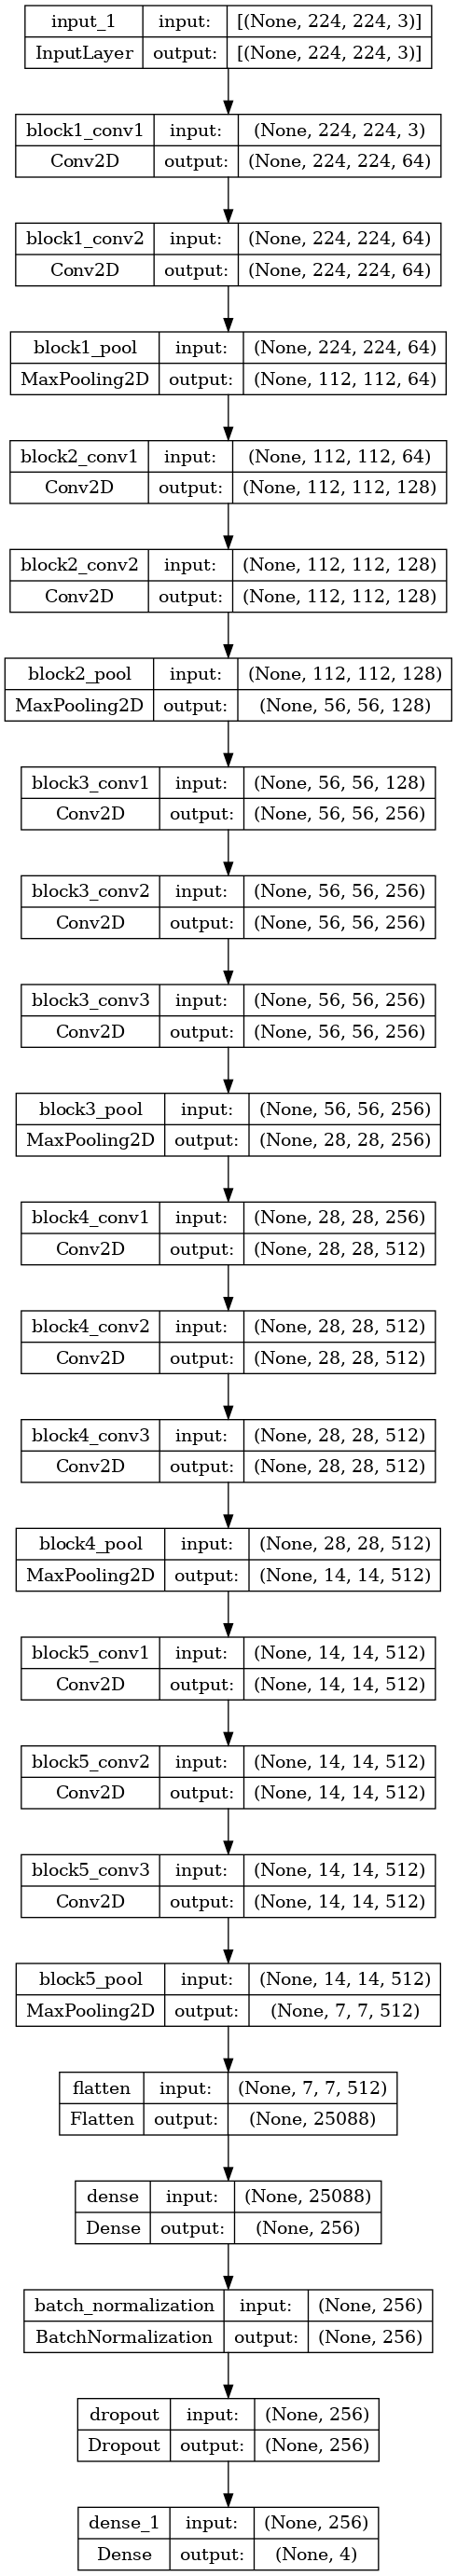

In [15]:
plot_model(model, show_shapes=True)

In [16]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', create_metrics()]
)

In [17]:
early_stopping = EarlyStopping(patience=5)

In [18]:
TOTAL_EPOCHS = 25

start_time = perf_counter()
history = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    steps_per_epoch=train_steps,
    callbacks=[early_stopping],
    validation_data=val_generator,
    validation_steps=val_steps
)
end_time = perf_counter()

Epoch 1/25
846/846 [==============================] - 169s 181ms/step - loss: 0.6229 - accuracy: 0.7908 - precision: 0.8207 - recall: 0.7564 - f1_score: 0.7839 - specificity: 0.9449 - sensitivity: 0.7564 - mcc: 0.7192 - auc: 0.9375 - val_loss: 2.8245 - val_accuracy: 0.3383 - val_precision: 0.3388 - val_recall: 0.3377 - val_f1_score: 0.3382 - val_specificity: 0.7803 - val_sensitivity: 0.3377 - val_mcc: 0.1181 - val_auc: 0.7402
Epoch 2/25
846/846 [==============================] - 110s 126ms/step - loss: 0.3346 - accuracy: 0.8896 - precision: 0.9023 - recall: 0.8782 - f1_score: 0.8897 - specificity: 0.9683 - sensitivity: 0.8782 - mcc: 0.8542 - auc: 0.9783 - val_loss: 0.6901 - val_accuracy: 0.7124 - val_precision: 0.7179 - val_recall: 0.7017 - val_f1_score: 0.7095 - val_specificity: 0.9081 - val_sensitivity: 0.7017 - val_mcc: 0.6145 - val_auc: 0.9304
Epoch 3/25
846/846 [==============================] - 106s 126ms/step - loss: 0.2598 - accuracy: 0.9145 - precision: 0.9206 - recall: 0.9054

In [19]:
execution_time = end_time - start_time

milliseconds = int(execution_time * 1000)
seconds, milliseconds = divmod(milliseconds, 1000)
minutes, seconds = divmod(seconds, 60)
hours, minutes = divmod(minutes, 60)

time_string = f"{hours} hours, " if hours else ""
time_string += f"{minutes} minutes, " if minutes else ""
time_string += f"{seconds} seconds, " if seconds else ""
time_string += f"{milliseconds} milliseconds"

print(f"Model training took {time_string}")

Model training took 19 minutes, 21 seconds, 16 milliseconds


In [20]:
_ = model.evaluate(test_generator, steps=test_steps)

264/264 [==============================] - 36s 137ms/step - loss: 0.2318 - accuracy: 0.9247 - precision: 0.9255 - recall: 0.9233 - f1_score: 0.9243 - specificity: 0.9752 - sensitivity: 0.9233 - mcc: 0.8992 - auc: 0.9886


In [21]:
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

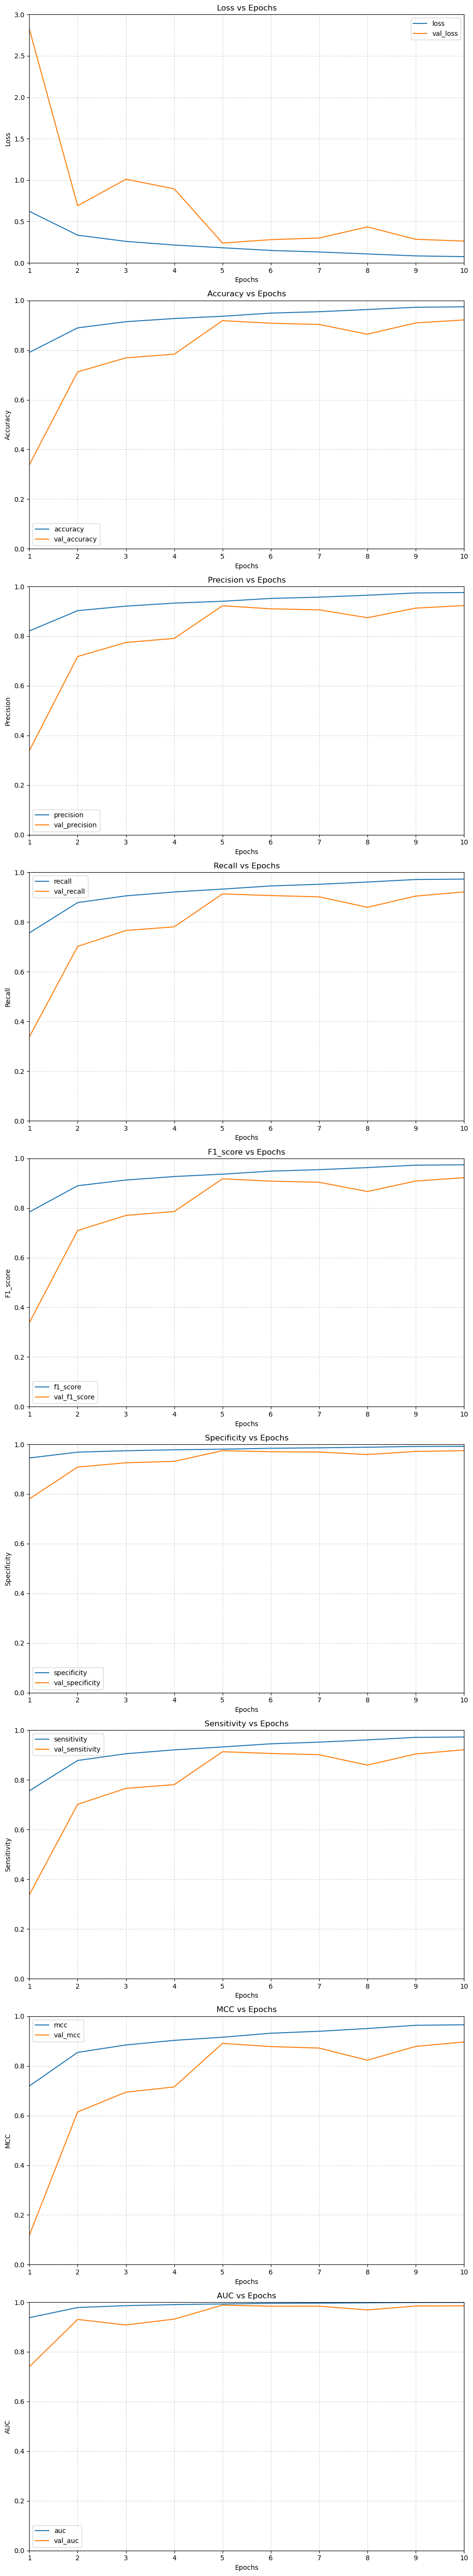

In [22]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
plot_metrics(history, metric_names)

In [23]:
def generate_classification_report(model, test_generator, test_steps, batch_size, target_names):
    """
    Generate a classification report, accuracy, and number of errors for a given model and test generator.

    Args:
        model (object): The trained model.
        test_generator (object): The test data generator.
        test_steps (int): The number of steps to iterate over the test generator.
        batch_size (int): The batch size for generating predictions.
        target_names (list): List of target class names for the classification report.

    Returns:
        tuple: A tuple containing true labels, predicted labels, and the classification report.
    """
    predicted_labels = []
    true_labels = []

    for i in range(test_steps):
        batch_data, batch_true_labels = next(test_generator)

        batch_predicted_labels = model.predict_on_batch(batch_data)
        batch_predicted_labels = np.argmax(batch_predicted_labels, axis=1)

        predicted_labels.extend(batch_predicted_labels)
        true_labels.extend(batch_true_labels)

    true_labels = np.array(true_labels)

    if len(true_labels[0]) > 1:
        true_labels = np.argmax(true_labels, axis=1)

    report = classification_report(
        true_labels,
        predicted_labels,
        target_names=target_names,
        digits=4,
        zero_division=1
    )

    accuracy = accuracy_score(true_labels, predicted_labels)
    num_errors = np.sum(true_labels != predicted_labels)

    print(report)
    print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

    return true_labels, predicted_labels

In [24]:
true_labels, predicted_labels = generate_classification_report(
    model, test_generator, test_steps, BATCH_SIZE, classes
)

                 precision    recall  f1-score   support

          COVID     0.9894    0.9423    0.9653       693
   Lung_Opacity     0.8476    0.9260    0.8850      1189
         Normal     0.9434    0.9191    0.9311      2051
Viral Pneumonia     1.0000    0.9175    0.9570       291

       accuracy                         0.9247      4224
      macro avg     0.9451    0.9262    0.9346      4224
   weighted avg     0.9279    0.9247    0.9255      4224

There were 318 errors in 4224 tests for an accuracy of  92.47


In [25]:
def confusion_matrix(true_labels, predicted_labels, num_classes):
    """
    Compute the confusion matrix.

    Args:
        true_labels (numpy.ndarray): Array of true labels.
        predicted_labels (numpy.ndarray): Array of predicted labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: Confusion matrix.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    np.add.at(cm, (true_labels, predicted_labels), 1)
    return cm

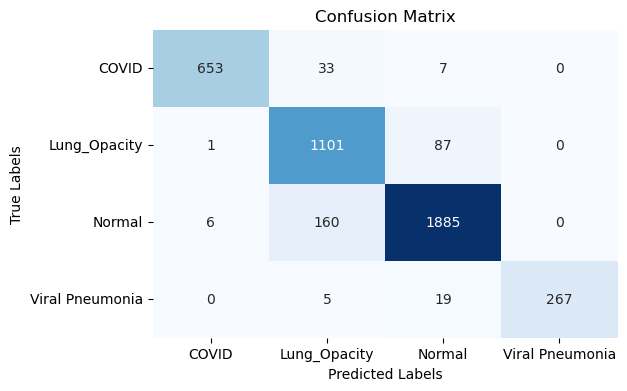

In [26]:
cm = confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()